In [3]:
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
import time
import shap


from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mplfinance.original_flavor import candlestick_ohlc


print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)

Numpy version: 1.21.5
Pandas version: 1.4.1
Matplotlib version: 3.5.1
Sklearn version: 1.0.2
Keras version: 2.8.0


In [4]:
class MeasureTime:
    def __init__(self):
        self.start = time.time()
    def kill(self):
        print ('Time elapsed: ' + time.strftime("%H:%M:%S", time.gmtime(time.time()-self.start)))
        del self
        
Notebook_timer = MeasureTime()
Notebook_timer.kill()

Time elapsed: 00:00:00


In [72]:
my_dataset = pd.read_csv('./Data/ndaq_long.csv')
my_dataset.drop(['Date', 'Volume', 'Change'], axis=1, inplace=True)

In [73]:
my_dataset = my_dataset[['Open', 'High', 'Low', 'Close']]
my_dataset

,Open,High,Low,Close
0,2098.37,2147.91,2086.00,2144.15
1,2140.51,2144.15,2122.78,2129.95
2,2136.60,2138.77,2104.38,2110.42
3,2110.92,2126.72,2103.77,2107.06
4,2109.22,2152.56,2107.06,2141.20
...,...,...,...,...
3983,13547.29,13585.08,13401.39,13411.96
3984,13584.69,13685.95,13317.74,13371.57
3985,13373.12,13679.43,13353.66,13643.59
3986,13647.42,13662.93,13345.22,13351.08


In [74]:
def graph_data_ohlc(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date=range(len(closep))

    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x+=1
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


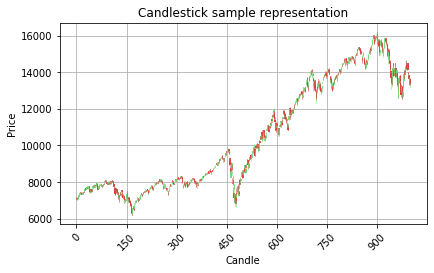

In [75]:
graph_data_ohlc(my_dataset.tail(1000).values)

In [76]:
def my_generator(data,lookback):
    final_output = []
    counter = 0
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            temp_list.append(candle)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

In [77]:
cell_timer = MeasureTime()
three_dim_sequence = np.asarray(my_generator(my_dataset.values[1:],3))
cell_timer.kill()

Time elapsed: 00:00:00


In [78]:
three_dim_sequence.shape

(3985, 3, 4)

Step 1


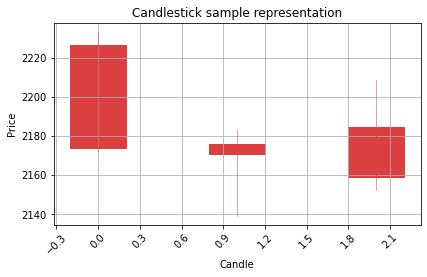

Step 2


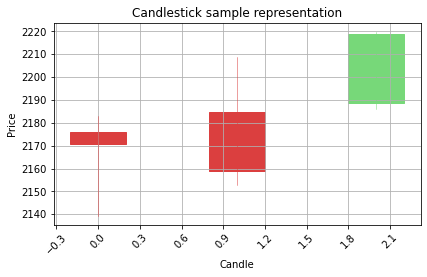

Step 3


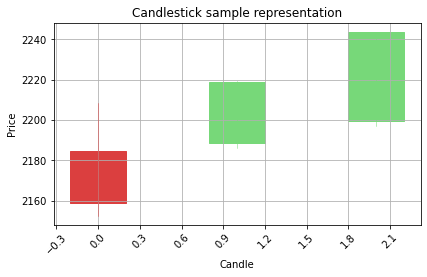

Step 4


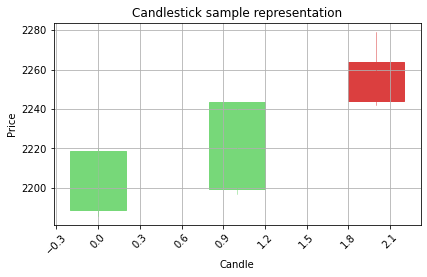

Step 5


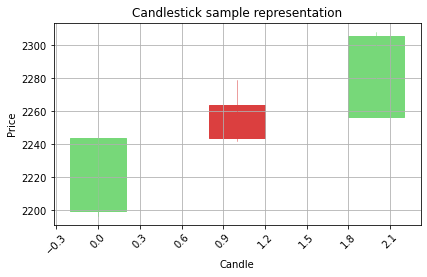

In [79]:
counter=0
for candle in three_dim_sequence[1000:1005]:
    counter=counter+1
    print('Step ' + str(counter))
    graph_data_ohlc(candle)

In [80]:
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]

    if conversion_array[3]>conversion_array[0]:
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]

    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[1]-conversion_array[3]


    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000,2)
    candlestick_data[2]=round(round(wicks_down,5)*10000,2)
    candlestick_data[3]=round(round(body_size,5)*10000,2)

    return candlestick_data

In [81]:
cell_timer = MeasureTime()
one_candle_data_ohlc=three_dim_sequence[1000:1010][5][1]
cell_timer.kill()

Time elapsed: 00:00:00


In [82]:
one_candle_data_ohlc

array([2256.48, 2307.98, 2256.44, 2305.88])

In [83]:
one_candle_data_ohlc_candle=ohlc_to_candlestick(one_candle_data_ohlc)

In [84]:
one_candle_data_ohlc_candle

[1, 21000.0, 400.0, 494000.0]

In [85]:
def my_generator_candle(data,lookback):
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

In [86]:
three_dim_sequence_candle=my_generator_candle(my_dataset.values[1:],3)

In [88]:
three_dim_sequence_candle[3640:3650]

array([[[0.0000e+00, 2.0400e+05, 1.7158e+06, 4.5910e+05],
        [1.0000e+00, 5.0680e+05, 4.9430e+05, 4.1750e+05],
        [1.0000e+00, 1.0690e+05, 6.8400e+05, 6.3620e+05]],

       [[1.0000e+00, 5.0680e+05, 4.9430e+05, 4.1750e+05],
        [1.0000e+00, 1.0690e+05, 6.8400e+05, 6.3620e+05],
        [1.0000e+00, 6.1840e+05, 1.2270e+05, 7.9200e+04]],

       [[1.0000e+00, 1.0690e+05, 6.8400e+05, 6.3620e+05],
        [1.0000e+00, 6.1840e+05, 1.2270e+05, 7.9200e+04],
        [1.0000e+00, 0.0000e+00, 2.2880e+05, 6.4910e+05]],

       [[1.0000e+00, 6.1840e+05, 1.2270e+05, 7.9200e+04],
        [1.0000e+00, 0.0000e+00, 2.2880e+05, 6.4910e+05],
        [1.0000e+00, 1.6280e+05, 4.5000e+03, 5.8950e+05]],

       [[1.0000e+00, 0.0000e+00, 2.2880e+05, 6.4910e+05],
        [1.0000e+00, 1.6280e+05, 4.5000e+03, 5.8950e+05],
        [1.0000e+00, 1.1770e+05, 4.9960e+05, 7.9600e+05]],

       [[1.0000e+00, 1.6280e+05, 4.5000e+03, 5.8950e+05],
        [1.0000e+00, 1.1770e+05, 4.9960e+05, 7.9600e+05],
    

In [89]:
def my_generator_candle_X_Y(data,lookback,MinMax = False):
    if MinMax==True:scaler = preprocessing.MinMaxScaler()
    first_row = 0
    arr = np.empty((0,lookback,4))
    arr3 = np.empty((0,lookback,4))
    Y_list = []
    for a in range(len(data)-lookback):
        temp_list = []
        temp_list_raw = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
            temp_list_raw.append(candle)
        temp_list3 = [np.asarray(temp_list)]
        templist4 = np.asarray(temp_list3)

        if MinMax==True:
            templist99 = scaler.fit_transform(templist4[0])
            arr = np.append(arr, [templist99], axis=0)
        else:
            arr = np.append(arr, templist4, axis=0)

        temp_list7 = [np.asarray(temp_list_raw)]
        templist8 = np.asarray(temp_list7)
        arr3 = np.append(arr3, templist8, axis=0)

        converted_data_prediction = ohlc_to_candlestick(data[first_row+lookback])
        Prediction = converted_data_prediction[0]
        Y_list.append(Prediction)

        first_row=first_row+1

    arr2 = np.asarray(Y_list)

    return arr,arr2,arr3

In [90]:
cell_timer = MeasureTime()
X,Y, X_raw = my_generator_candle_X_Y(my_dataset.values,3,MinMax=False)
cell_timer.kill()

Time elapsed: 00:00:00


In [91]:
print('Shape of X ' + str(X.shape))
print('Shape of Y ' + str(Y.shape))
print('Shape of X raw ohlc ' + str(X_raw.shape))

Shape of X (3985, 3, 4)
Shape of Y (3985,)
Shape of X raw ohlc (3985, 3, 4)


In [92]:
unique, counts = np.unique(Y, return_counts=True)
predictions_type = dict(zip(unique, counts))
print('Bull: ' + str((predictions_type[1])) + ' percent: ' + str(round((predictions_type[1]*100)/len(Y),2)) + '%')
print('Bear: ' + str((predictions_type[0])) + ' percent: ' + str(round((predictions_type[0]*100)/len(Y),2)) + '%')
print('Total: ' + str(len(Y)))

Bull: 2182 percent: 54.76%
Bear: 1803 percent: 45.24%
Total: 3985


Correct prediction would be Bullish ---^


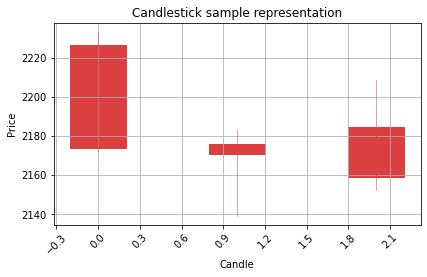

Correct prediction would be Bullish ---^


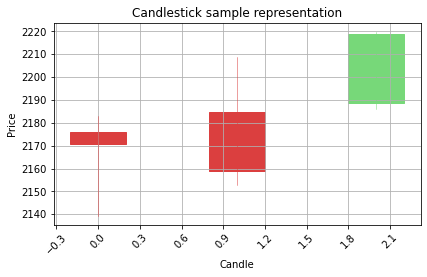

Correct prediction would be Bearish ---v


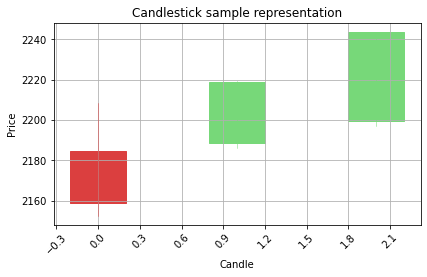

Correct prediction would be Bullish ---^


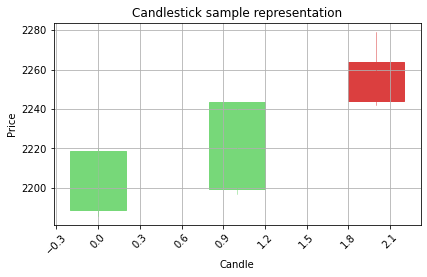

Correct prediction would be Bullish ---^


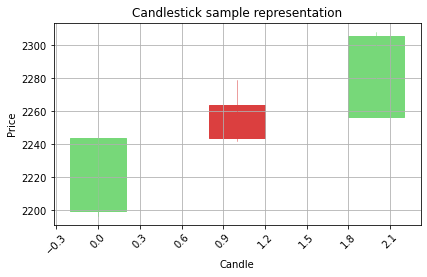

In [93]:
for a in range(5):
    b=a+1000
    if Y[b] == 1:print('Correct prediction would be Bullish ---^')
    if Y[b] == 0:print('Correct prediction would be Bearish ---v')
    graph_data_ohlc(X_raw[b])

In [111]:
from keras import layers
from tensorflow.keras.optimizers import RMSprop


model = Sequential()
model.add(layers.CuDNNLSTM(units = 12,return_sequences=True, input_shape = (None, X.shape[-1])))
model.add(layers.CuDNNLSTM(units = 24))
model.add(layers.Dense(units = 1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [112]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_8 (CuDNNLSTM)    (None, None, 12)          864       
                                                                 
 cu_dnnlstm_9 (CuDNNLSTM)    (None, 24)                3648      
                                                                 
 dense_4 (Dense)             (None, 1)                 25        
                                                                 
Total params: 4,537
Trainable params: 4,537
Non-trainable params: 0
_________________________________________________________________


In [113]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.3)

X_train_raw, X_val_and_test_raw= train_test_split(X_raw, test_size=0.3)
X_val_raw, X_test_raw = train_test_split(X_val_and_test_raw, test_size=0.3)

In [114]:
print('Training data: ' + 'X Input shape: ' + str(X_train.shape) + ', ' + 'Y Output shape: ' + str(Y_train.shape) + ', ' + 'datetime shape: ' + str(Y_train.shape))
print('Validation data: ' + 'X Input shape: ' + str(X_val.shape) + ', ' + 'Y Output shape: ' + str(Y_val.shape) + ', ' + 'datetime shape: ' + str(Y_val.shape))
print('Test data: ' + 'X Input shape: ' + str(X_test.shape) + ', ' + 'Y Output shape: ' + str(Y_test.shape) + ', ' + 'datetime shape: ' + str(Y_test.shape))

Training data: X Input shape: (2789, 3, 4), Y Output shape: (2789,), datetime shape: (2789,)
Validation data: X Input shape: (837, 3, 4), Y Output shape: (837,), datetime shape: (837,)
Test data: X Input shape: (359, 3, 4), Y Output shape: (359,), datetime shape: (359,)


In [115]:
history = model.fit(X_train, Y_train,batch_size=500, epochs=30,validation_data=(X_val, Y_val))

Epoch 1/30
6/6 [==============================] - 1s 47ms/step - loss: 0.6878 - acc: 0.5554 - val_loss: 0.6947 - val_acc: 0.5257
Epoch 2/30
6/6 [==============================] - 0s 13ms/step - loss: 0.6870 - acc: 0.5572 - val_loss: 0.6940 - val_acc: 0.5257
Epoch 3/30
6/6 [==============================] - 0s 13ms/step - loss: 0.6866 - acc: 0.5572 - val_loss: 0.6936 - val_acc: 0.5257
Epoch 4/30
6/6 [==============================] - 0s 12ms/step - loss: 0.6864 - acc: 0.5572 - val_loss: 0.6947 - val_acc: 0.5257
Epoch 5/30
6/6 [==============================] - 0s 13ms/step - loss: 0.6861 - acc: 0.5572 - val_loss: 0.6938 - val_acc: 0.5257
Epoch 6/30
6/6 [==============================] - 0s 13ms/step - loss: 0.6861 - acc: 0.5572 - val_loss: 0.6942 - val_acc: 0.5257
Epoch 7/30
6/6 [==============================] - 0s 13ms/step - loss: 0.6859 - acc: 0.5572 - val_loss: 0.6945 - val_acc: 0.5257
Epoch 8/30
6/6 [==============================] - 0s 13ms/step - loss: 0.6858 - acc: 0.5572 - val

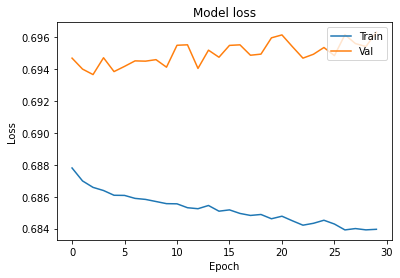

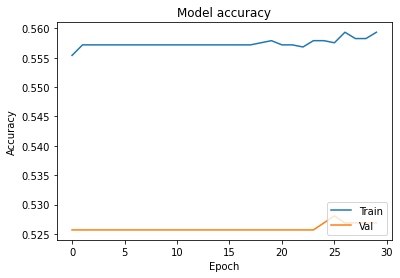

In [116]:
# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


In [117]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

12/12 [==============================] - 0s 9ms/step - loss: 0.6955 - acc: 0.5265
Test accuracy: 0.5264623761177063


0
Correct prediction is Bearish
Model prediction is Bullish
LOST


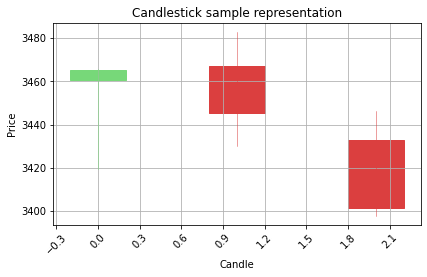

1
Correct prediction is Bullish
Model prediction is Bullish
WON


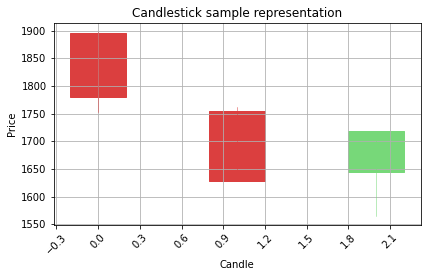

0
Correct prediction is Bearish
Model prediction is Bullish
LOST


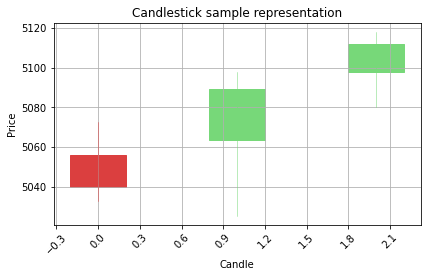

1
Correct prediction is Bullish
Model prediction is Bullish
WON


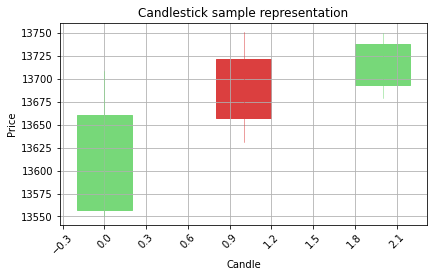

0
Correct prediction is Bearish
Model prediction is Bullish
LOST


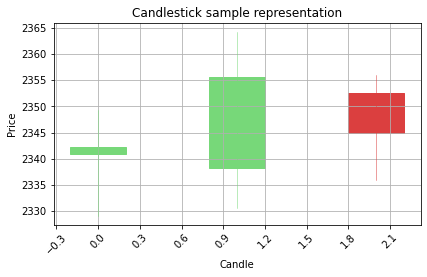

0
Correct prediction is Bearish
Model prediction is Bullish
LOST


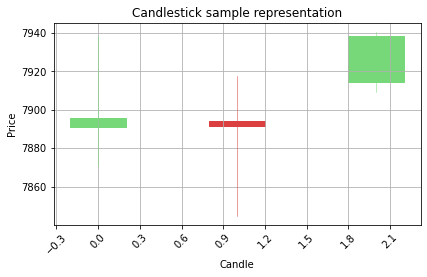

0
Correct prediction is Bearish
Model prediction is Bullish
LOST


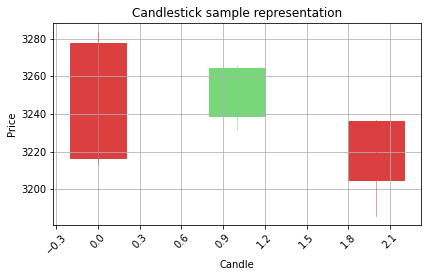

0
Correct prediction is Bearish
Model prediction is Bullish
LOST


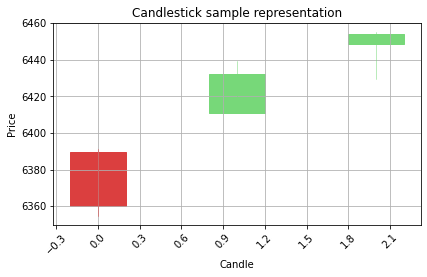

0
Correct prediction is Bearish
Model prediction is Bullish
LOST


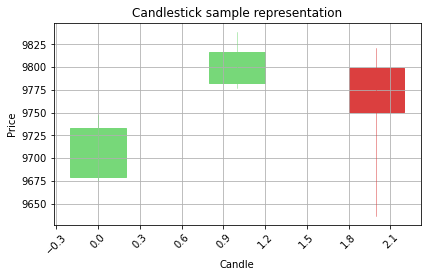

1
Correct prediction is Bullish
Model prediction is Bullish
WON


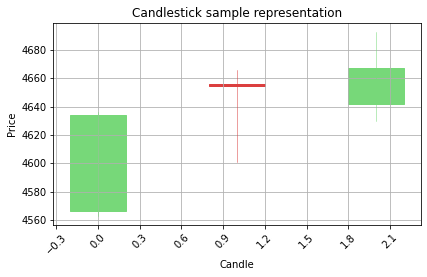

1
Correct prediction is Bullish
Model prediction is Bullish
WON


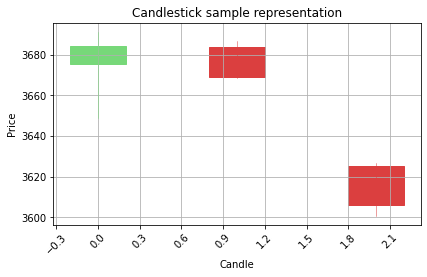

0
Correct prediction is Bearish
Model prediction is Bullish
LOST


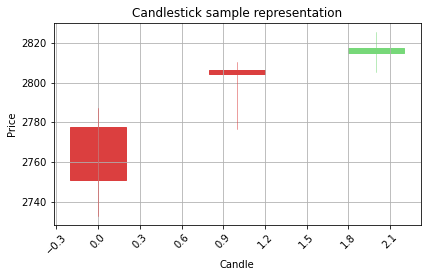

0
Correct prediction is Bearish
Model prediction is Bullish
LOST


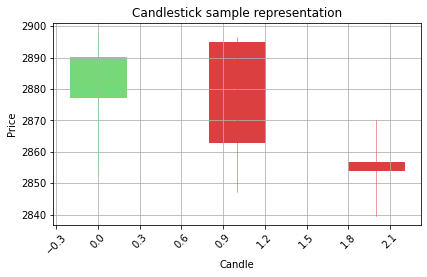

1
Correct prediction is Bullish
Model prediction is Bullish
WON


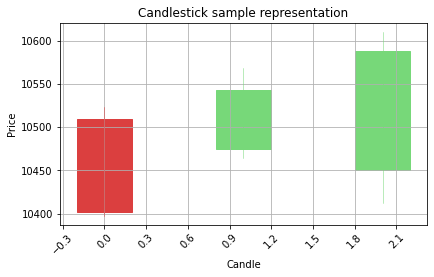

0
Correct prediction is Bearish
Model prediction is Bullish
LOST


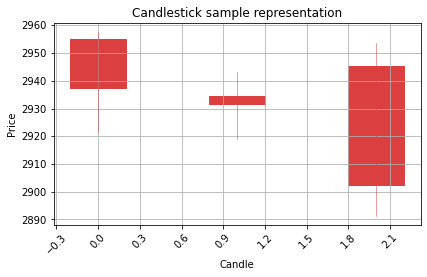

0
Correct prediction is Bearish
Model prediction is Bullish
LOST


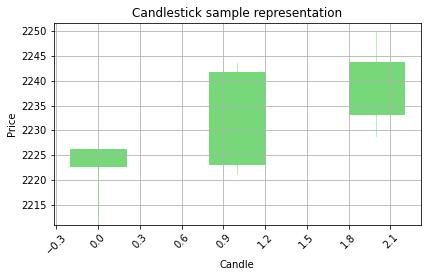

0
Correct prediction is Bearish
Model prediction is Bullish
LOST


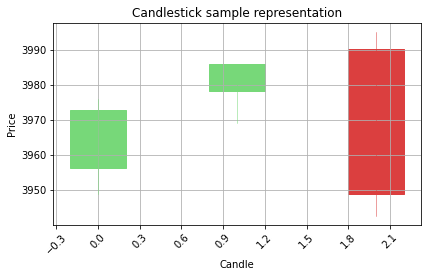

1
Correct prediction is Bullish
Model prediction is Bullish
WON


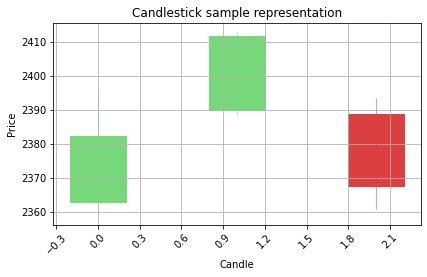

0
Correct prediction is Bearish
Model prediction is Bullish
LOST


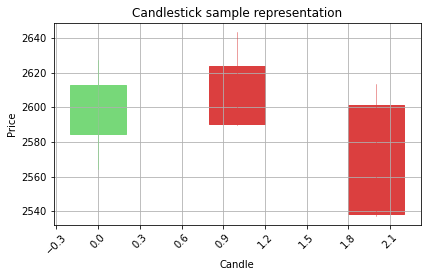

Won: 6 Lost: 13
Success rate: 31.58%


In [110]:
cell_timer = MeasureTime()
counter = 0
won = 0
lost = 0
test = model.predict(X_test)
alpha_distance = 0.35

for a in test:
#     print(a)
#     print("a : ", a)
#     print("cond 1 ", (1-alpha_distance))
#     print("cond 2 ", alpha_distance)
    if a > (1-alpha_distance) or a < alpha_distance :
        print(Y_test[counter])
        if Y_test[counter] == 1:print('Correct prediction is Bullish')
        if Y_test[counter] == 0:print('Correct prediction is Bearish')
        if a > (1-alpha_distance):print('Model prediction is Bullish')
        if a < alpha_distance:print('Model prediction is Bearish')

        if (a > (1-alpha_distance) and Y_test[counter] == 1) or (a < alpha_distance and Y_test[counter] == 0):
            won=won+1
            print('WON')
        else:
            print('LOST')
            lost=lost+1

        graph_data_ohlc(X_test_raw[counter])

    counter=counter+1
print('Won: ' + str(won) + ' Lost: ' + str(lost))
print('Success rate: ' + str(round((won*100)/(won+lost), 2)) + '%')

In [109]:
Y_test[0]

0